In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import quandl

import cvxportfolio as cp

Download the problem data from Quandl. We select four liquid stocks, and the risk-free rate.

In [3]:
tickers = ['AMZN', 'GOOGL', 'MCD', 'NKE']
start_date='2012-01-01'
end_date='2016-12-31'
returns = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Close'].pct_change())
                for ticker in tickers]))
returns[["USDOLLAR"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/(250*100)
returns = returns.fillna(method='ffill').iloc[1:]

returns.head()

,AMZN,GOOGL,MCD,NKE,USDOLLAR
Date,,,,,
2012-01-04,-0.008490,0.004313,0.005565,0.014565,8.000000e-07
2012-01-05,0.000563,-0.013871,0.004427,-0.000611,8.000000e-07
2012-01-06,0.028152,-0.013642,0.007713,-0.001732,8.000000e-07
2012-01-09,-0.022178,-0.042399,-0.009543,0.003674,4.000000e-07
2012-01-10,0.004368,0.001092,0.000602,0.001220,8.000000e-07


We compute empirical estimators of the first and second moments of the returns. We shift them by one unit (so at every day we present the optimizer with only past data).

In [4]:
r_hat = returns.rolling(window=250, min_periods=250).mean().shift(1).dropna()
Sigma_hat = returns.rolling(window=250, min_periods=250).cov().shift(1,0,0).dropna()

r_hat.head()

,AMZN,GOOGL,MCD,NKE,USDOLLAR
Date,,,,,
2013-01-03,0.001646,0.000438,-0.000204,0.000439,0.000004
2013-01-04,0.001698,0.000423,-0.000203,0.000422,0.000004
2013-01-07,0.001706,0.000557,-0.000256,0.000463,0.000004
2013-01-08,0.001737,0.000595,-0.000239,0.000476,0.000004
2013-01-09,0.001795,0.000756,-0.000200,0.000419,0.000004


Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

In [5]:
tcost_model=cp.TcostModel(half_spread=10E-4)
hcost_model=cp.HcostModel(borrow_costs=1E-4)

We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [6]:
risk_model = cp.FullSigma(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 5., 1., 1.
leverage_limit = cp.LeverageLimit(3)

spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model, gamma_hold*hcost_model],
                                constraints=[leverage_limit])

We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

In [7]:
market_sim=cp.MarketSimulator(returns, [tcost_model, hcost_model], cash_key='USDOLLAR') 
init_portfolio = pd.Series(index=returns.columns, data=0.)
init_portfolio.USDOLLAR = 100
result = market_sim.run_backtest(init_portfolio,
                               start_time='2013-01-03',  end_time='2016-12-31',  
                               policy=spo_policy)

result.summary()

Number of periods: 1007
Initial timestamp: 2013-01-03 00:00:00
Final timestamp: 2016-12-31 00:00:00
Portfolio return: 12.05%
Excess return: 11.93%
Excess risk: 17.50%
Sharpe ratio: 0.68
Max. drawdown: 21.34%
Turnover: 84.01%
Average policy time: 0.042 sec
Average simulator time: 0.006 sec


The total value of the portfolio in time.

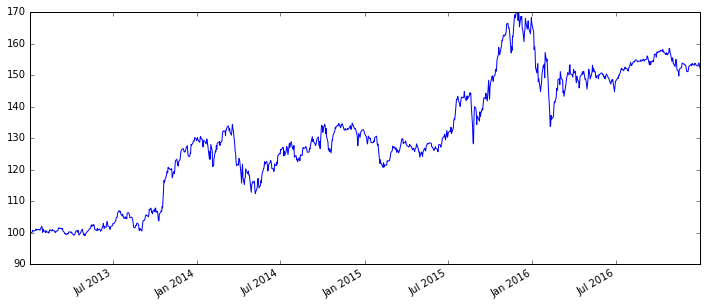

In [9]:
result.v.plot(figsize=(12,5))

The weights vector of the portfolio in time.

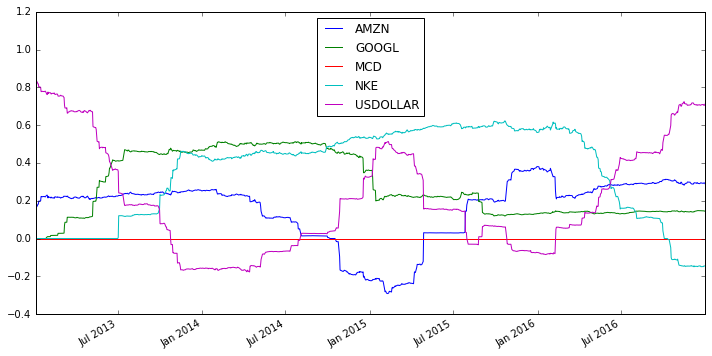

In [10]:
result.w.plot(figsize=(12,6))